# Qiita

* 対象データ
  * 期間: 2017/12/15〜2018/12/3
  * データ件数: 87,990記事
  * 内容: 記事データ（item）※本文（body）は除く
  * 取得方法: API経由: [Qiitaの記事データをQiita API, Scrapyで収集](https://qiita.com/nkmk/items/fbac13cd05b80334eb2b)
  
## バズる記事とは？

ざっくり

* いいね数（likes_count）が多い記事

参考記事（[お前らの記事のタイトルは間違っている〜爆速で誰でもできるQiitaでバズらせる6個の必殺技まとめ]）によると `タイトルに数字を入れてボリューム感を出す` という手法が良いらしい。

では数字を何個入れるとよいのか調べてみる。

  
## 参考資料

* Qiita: [お前らの記事のタイトルは間違っている〜爆速で誰でもできるQiitaでバズらせる6個の必殺技まとめ](https://qiita.com/SugarShootingStar/items/bba0fab1e55936e7234a)
* Qiita: [Qiitaの記事データをQiita API, Scrapyで収集](https://qiita.com/nkmk/items/fbac13cd05b80334eb2b)
* blog: [Bayesian Poisson A/B Testing in PYMC3 on Python](http://barnesanalytics.com/bayesian-poisson-ab-testing-in-pymc3-on-python)

In [79]:
import numpy as np
import pandas as pd

from pandas_summary import DataFrameSummary

import matplotlib.pyplot as plt
%matplotlib inline

import pymc3 as pm

import collections
import string

Qiita APIから取得済みデータを読み込む

In [80]:
df = pd.read_csv('input/summary.csv')

データの形

* カラム数: 10
* レコード数: 87990

In [81]:
print("カラム数: {}".format(df.shape[1]))
print("レコード数: {}".format(df.shape[0]))

カラム数: 10
レコード数: 87990


カラム一覧

In [82]:
for c in df.columns:
    print(c)

title
id
created_at
updated_at
likes_count
comments_count
tags_str
user_id
user_permanent_id
url


In [83]:
df.head(3).T

,0,1,2
title,DynamoDB ローカルでチュートリアル,C++で初めてのゲーム開発する時に、気をつけて欲しいこと,LSTMの簡易まとめ
id,022f5c5b4e45f42727e9,1b7ab644e7de7709b073,636ec5e15df4e57f78a0
created_at,2017-12-31T08:54:37+09:00,2017-12-31T08:39:29+09:00,2017-12-31T08:32:55+09:00
updated_at,2017-12-31T08:54:37+09:00,2017-12-31T14:21:16+09:00,2018-01-04T11:16:21+09:00
likes_count,1,35,2
comments_count,0,0,0
tags_str,"AWS,チュートリアル,DynamoDB",C++,"機械学習,深層学習,LSTM,TensorFlow"
user_id,h2m_kinoko,4_mio_11,matsui-k20xx
user_permanent_id,119864,36899,214997
url,https://qiita.com/h2m_kinoko/items/022f5c5b4e4...,https://qiita.com/4_mio_11/items/1b7ab644e7de7...,https://qiita.com/matsui-k20xx/items/636ec5e15...


# EDA

要約統計量

In [84]:
DataFrameSummary(df).summary()

,title,id,created_at,updated_at,likes_count,comments_count,tags_str,user_id,user_permanent_id,url
count,NaN,NaN,NaN,NaN,87990,87990,NaN,NaN,87990,NaN
mean,NaN,NaN,NaN,NaN,8.14695,0.319536,NaN,NaN,147979,NaN
std,NaN,NaN,NaN,NaN,58.1444,1.69247,NaN,NaN,88418.7,NaN
min,NaN,NaN,NaN,NaN,0,0,NaN,NaN,29,NaN
25%,NaN,NaN,NaN,NaN,0,0,NaN,NaN,65978,NaN
50%,NaN,NaN,NaN,NaN,1,0,NaN,NaN,148882,NaN
75%,NaN,NaN,NaN,NaN,4,0,NaN,NaN,227518,NaN
max,NaN,NaN,NaN,NaN,3583,104,NaN,NaN,322336,NaN
counts,87990,87990,87990,87990,87990,87990,87990,87990,87990,87990
uniques,87815,87990,87815,87825,603,54,54919,21091,21091,87990


## いいね数

いいね数の分布

(array([8.7635e+04, 2.2500e+02, 6.4000e+01, 3.8000e+01, 1.6000e+01,
        6.0000e+00, 4.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   0. ,  358.3,  716.6, 1074.9, 1433.2, 1791.5, 2149.8, 2508.1,
        2866.4, 3224.7, 3583. ]),
 <a list of 10 Patch objects>)

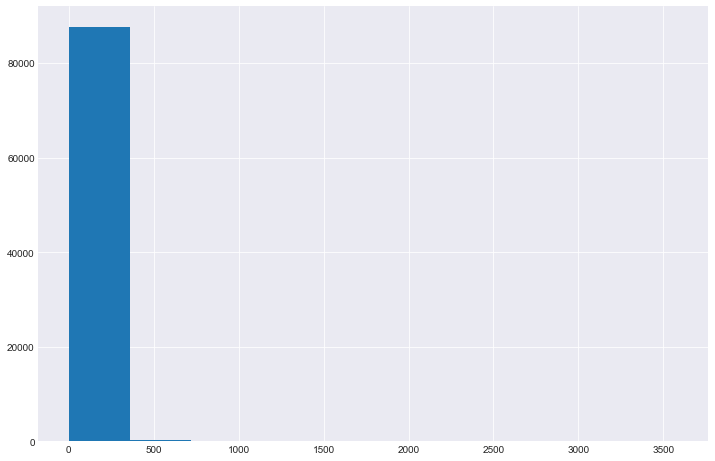

In [591]:
plt.figure(figsize=(12, 8))
plt.hist(df['likes_count'])

いいねが0の割合

* いいね0の記事は全体の約32%

In [89]:
print("{:.2f}%".format(len(df[df['likes_count']==0]) / len(df) * 100))

31.65%


いいね数の分布がエグいの対数変換してみる

* 対数変換すると少しましになる

(array([4.6195e+04, 2.2701e+04, 1.1175e+04, 4.9110e+03, 1.5020e+03,
        6.8100e+02, 4.0800e+02, 2.8200e+02, 1.1500e+02, 2.0000e+01]),
 array([0.        , 0.81842348, 1.63684695, 2.45527043, 3.27369391,
        4.09211739, 4.91054086, 5.72896434, 6.54738782, 7.3658113 ,
        8.18423477]),
 <a list of 10 Patch objects>)

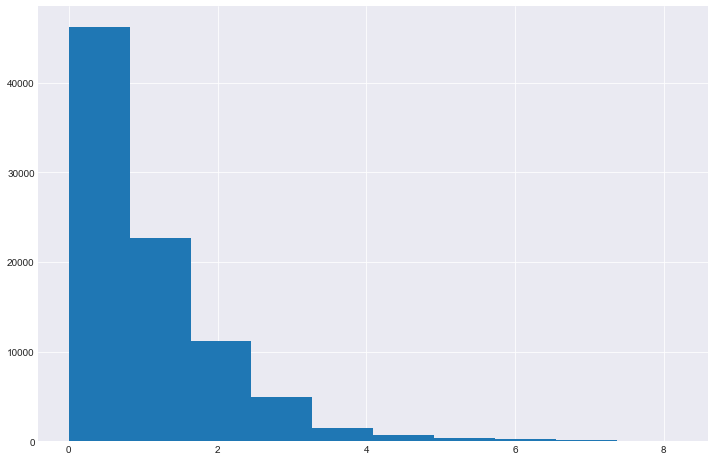

In [592]:
plt.figure(figsize=(12, 8))
plt.hist(np.log(df['likes_count'].values+1))

## いいね数の詳細

In [93]:
df_with_likes = df[df['likes_count']>0]
print("count: {}".format(len(df_with_likes)))

count: 60137


いいね数が多い記事のTop20

* いいね数が多い記事は平均してコメントも多い傾向にある

In [94]:
df_with_likes.sort_values(by='likes_count', ascending=False)[[
    "title",
    "tags_str",
    "comments_count",
    "likes_count",
    "url"
]].head(20)

,title,tags_str,comments_count,likes_count,url
1054,イマドキのJavaScriptの書き方2018,JavaScript,45,3583,https://qiita.com/shibukawa/items/19ab5c381bbb...
33967,開設後３週間で収益１０万円を得た個人開発サイトでやったことの全部を公開する,"Ruby,JavaScript,Heroku,AWS,個人開発",37,2686,https://qiita.com/jabba/items/1a49e860a09a613b...
37148,2018年の最先端バックエンドエンジニアに必要なスキルについて考えてみました。,"AWS,gcp,キャリア",15,2487,https://qiita.com/poly_soft/items/fb649573c19b...
69409,[2018] 個人でも使える！おすすめAPI一覧,"Python,Instagram,GoogleCloudPlatform",15,2439,https://qiita.com/mikan3rd/items/ba4737023f08b...
33628,コーディングをするときに鼻血がでるほど便利なwebツールリスト(随時更新予定),"正規表現,Web,tool,coding,naming",18,2404,https://qiita.com/isuke/items/7fcc5eb0b985005b...
65115,Chrome拡張の高速な英語辞書ツールをつくりました(Mouse Dictionary),"JavaScript,Chrome,chrome-extension,English",31,2349,https://qiita.com/wtetsu/items/c43232c6c44918e...
73204,エンジニアは全員技術記事を書くことを習慣化した方がいいぞ,"Qiita,翻訳,アウトプット,新人プログラマ応援",44,2090,https://qiita.com/HiromuMasuda0228/items/a71de...
68548,なぜ我々はいまだに文字列でコメントを書いているのか,"Emacs,SublimeText3,コメント,Visual,VSCode",23,2062,https://qiita.com/tkrkt/items/2fc9a9a59ce679aa...
70338,もっと気軽にアウトプットできる技術ブログサービス「Qrunch（クランチ）」をリリースした【...,"Ruby,Markdown,RubyOnRails,Webサービス,個人開発",34,1952,https://qiita.com/c0domisu/items/95a561d163d26...
10263,【今日からできる】コミットメッセージに 「プレフィックス」 をつけるだけで、開発効率が上がった話,"Git,GitHub,devops,チーム,新人プログラマ応援",33,1947,https://qiita.com/numanomanu/items/45dd285b286...


# タイトルに含まれる数字の数を数える

半角数字と全角数字をカウント

In [587]:
def count_digits(s):
    c = collections.Counter(s)
    return {k[0]: k[1] for k in c.items() if (k[0] in '０１２３４５６７８９') or (k[0] in string.digits)}

数字の文字数

In [99]:
digit_lengths = [sum(count_digits(x).values()) for x in df["title"].values]

In [100]:
digit_lengths[:10]

[0, 0, 0, 2, 0, 0, 0, 0, 1, 1]

In [101]:
df["title"].values[:10]

array(['DynamoDB ローカルでチュートリアル', 'C++で初めてのゲーム開発する時に、気をつけて欲しいこと',
       'LSTMの簡易まとめ', 'Mastodonで始めるPythonプログラミング！腕試しテスト50本ノック（初級編）',
       'create-react-appでReactの開発環境を構築する', 'Hyperappを読む',
       'matplotlib の legend(凡例) の 位置を調整する legend bbox_to_anchor loc',
       'ノートンいれたらMacが再起動から復帰しなくなった。(復旧済み)', 'Cloud9上でJupyterを動かせる環境を作ってみた',
       'AWSのEC2を使ってJupyterをブラウザから使えるようにする方法'], dtype=object)

## 前処理

In [195]:
df.shape, len(title_lengths), len(digit_lengths), len(hiragana_lengths), len(katakana_lengths)

((87990, 11), 87990, 87990, 87990, 87990)

In [196]:
df["digit_count"] = digit_lengths
df["has_digit"] = (df["digit_count"] > 0) * 1

In [589]:
print("{:.2f}%".format(len(df[df["has_digit"] == 1]) / len(df)* 100))

26.64%


In [594]:
df.sort_values(by='likes_count', ascending=False)[[
    "title", "likes_count",
    "comments_count",
    "has_digit",
    "tags_str",
    "digit_count"
]].head(50)

,title,likes_count,comments_count,has_digit,tags_str,digit_count
1054,イマドキのJavaScriptの書き方2018,3583,45,1,JavaScript,4
33967,開設後３週間で収益１０万円を得た個人開発サイトでやったことの全部を公開する,2686,37,1,"Ruby,JavaScript,Heroku,AWS,個人開発",3
37148,2018年の最先端バックエンドエンジニアに必要なスキルについて考えてみました。,2487,15,1,"AWS,gcp,キャリア",4
69409,[2018] 個人でも使える！おすすめAPI一覧,2439,15,1,"Python,Instagram,GoogleCloudPlatform",4
33628,コーディングをするときに鼻血がでるほど便利なwebツールリスト(随時更新予定),2404,18,0,"正規表現,Web,tool,coding,naming",0
65115,Chrome拡張の高速な英語辞書ツールをつくりました(Mouse Dictionary),2349,31,0,"JavaScript,Chrome,chrome-extension,English",0
73204,エンジニアは全員技術記事を書くことを習慣化した方がいいぞ,2090,44,0,"Qiita,翻訳,アウトプット,新人プログラマ応援",0
68548,なぜ我々はいまだに文字列でコメントを書いているのか,2062,23,0,"Emacs,SublimeText3,コメント,Visual,VSCode",0
70338,もっと気軽にアウトプットできる技術ブログサービス「Qrunch（クランチ）」をリリースした【...,1952,34,0,"Ruby,Markdown,RubyOnRails,Webサービス,個人開発",0
10263,【今日からできる】コミットメッセージに 「プレフィックス」 をつけるだけで、開発効率が上がった話,1947,33,0,"Git,GitHub,devops,チーム,新人プログラマ応援",0


数字使いすぎているタイトルは削除

In [585]:
df_new = df[df["digit_count"] < 27] # 数字が27未満のレコードのみ抽出

In [550]:
digit_unique = df_new["digit_count"].unique()
digit_unique.sort()
digit_unique

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

# モデリング

In [579]:
with pm.Model() as model:
    mu = pm.HalfNormal("mu", sd=1, shape=len(digit_unique))
    obs = pm.Poisson("obs", mu=mu[df_new["digit_count"].values], observed=df_new["likes_count"].values)

In [580]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
Sampling 2 chains: 100%|██████████| 2000/2000 [02:06<00:00, 15.78draws/s]
The acceptance probability does not match the target. It is 0.9425571729237275, but should be close to 0.8. Try to increase the number of tuning steps.


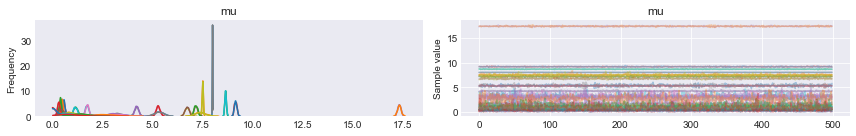

In [581]:
pm.traceplot(trace);

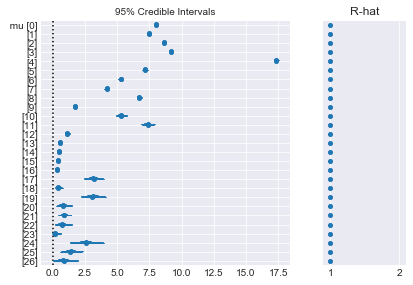

In [582]:
pm.forestplot(trace);

* 数字が4個の場合は、0個の場合と比べて2倍強い
    * 一部のいいね数が多い記事のデータによって偏っているので一概には言えない

In [583]:
pm.summary(trace).sort_values(by='mean', ascending=False)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu__4,17.339367,0.087112,0.001998,17.171969,17.508300,2311.073653,0.999000
mu__3,9.157161,0.064027,0.001676,9.040399,9.277893,1622.397521,0.999605
mu__2,8.652965,0.040266,0.000951,8.575305,8.728249,1881.042143,0.999354
mu__0,8.002039,0.011009,0.000270,7.980336,8.023062,1835.409262,0.999385
mu__1,7.512486,0.029177,0.000632,7.454941,7.571012,2899.976859,1.000102
mu__11,7.390361,0.261843,0.006959,6.932836,7.954501,1439.865802,0.999478
mu__5,7.169802,0.093453,0.001909,7.005426,7.368855,2497.543927,0.999014
mu__8,6.736088,0.109026,0.002650,6.528591,6.944114,1733.535940,0.999830
mu__10,5.335247,0.227185,0.004826,4.895559,5.754932,1984.982729,0.999462
mu__6,5.284698,0.096110,0.002264,5.107387,5.480108,2231.610085,0.999026


とりあえず数字四桁（＝2018年などの年）を入れると良いことがわかる

In [584]:
df[df["digit_count"] == 4].describe()

,likes_count,comments_count,user_permanent_id,title_length,digit_count,hiragana_count,katakana_count,has_digit
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.0,2325.000000,2325.000000,2325.0
mean,17.466237,0.367312,140899.220215,40.652043,4.0,5.167312,4.228387,1.0
std,132.669167,2.714492,89800.135485,20.214975,0.0,5.224146,4.876342,0.0
min,0.000000,0.000000,43.000000,5.000000,4.0,0.000000,0.000000,1.0
25%,0.000000,0.000000,55223.000000,28.000000,4.0,1.000000,0.000000,1.0
50%,1.000000,0.000000,136761.000000,37.000000,4.0,4.000000,3.000000,1.0
75%,4.000000,0.000000,224453.000000,48.000000,4.0,7.000000,6.000000,1.0
max,3583.000000,102.000000,321330.000000,236.000000,4.0,89.000000,45.000000,1.0


In [609]:
df[df.title.str.contains("2018")].describe()

,likes_count,comments_count,user_permanent_id,title_length,digit_count,hiragana_count,katakana_count,has_digit
count,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.0
mean,24.631362,0.336314,126045.844567,39.841128,6.375516,4.343191,3.548831,1.0
std,160.482120,1.852166,89786.390337,17.713486,2.896585,4.318030,4.677782,0.0
min,0.000000,0.000000,43.000000,8.000000,4.000000,0.000000,0.000000,1.0
25%,0.000000,0.000000,44307.750000,29.000000,4.000000,0.000000,0.000000,1.0
50%,2.000000,0.000000,108201.500000,36.000000,6.000000,4.000000,2.000000,1.0
75%,6.000000,0.000000,203892.250000,49.000000,8.000000,7.000000,6.000000,1.0
max,3583.000000,45.000000,319937.000000,160.000000,28.000000,30.000000,25.000000,1.0
